### Временные ряды и обработка сигналов. Лабораторная работа №4
|   Группа          |   Вариант         |   ФИО             |   
|   :------------:  |   :------------:  |   :------------:  |
|   М092501(71)     |   16 (0)          |   Шарибжанов И.Т. |

In [ ]:
# Устанавливаем необходимые библиотеки для работы с нейросетевыми моделями прогнозирования и виджетами
%pip install neuralforecast
%pip install -U ipywidgets
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

In [2]:
# Импорт основных библиотек для работы с данными, построения графиков и оценки качества моделей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импорт фреймворка neuralforecast и используемых моделей (NBEATS, NHITS)
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.losses.pytorch import HuberLoss

# Метрики качества прогнозов (MAE и RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Чтение и подготовка данных

In [3]:
# Читаем исходный CSV-файл с временным рядом и приводим столбец дат к типу datetime
rdf = pd.read_csv('data/0.data-n-4w-251201.csv')
# Преобразуем столбец 'ds' в формат даты/времени для удобства ресемплирования и фильтрации
rdf['ds'] = pd.to_datetime(rdf['ds'])

In [4]:
# Подготовка данных: ресемплирование и усреднение наблюдений по времени
# Сначала приводим данные к минутной частоте, затем будем переходить к 5-минутным интервалам
# Учитываем недельную сезонность: в дальнейшем будем использовать полные недели как окно истории

df = rdf.resample('1min', on='ds').mean().reset_index()
df.columns = ['ds', 'y']  # Переименовываем столбцы: 'ds' — дата/время, 'y' — значение ряда
df['unique_id'] = 1       # Идентификатор ряда (требуется для формата neuralforecast)
one_day = 1*60*24         # Количество минут в сутках
freq = '5min'             # Целевая частота временного ряда

# Ресемплирование до 5 минут (средние значения по каждому 5-минутному интервалу)
df = df.resample(freq, on='ds').mean().reset_index()
one_day = 24*12           # Количество 5-минутных интервалов в сутках
one_week = one_day * 7    # Количество точек в одной неделе

# Диапазон данных: 2025-09-21 21:00:00+00 — 2025-12-01 20:59:00+00
# Делаем сплит по неделям (ориентир — конец недели 23:55 UTC)
train_end = pd.Timestamp('2025-11-16 23:55:00+00:00')  # полные недели на обучение
val_end = pd.Timestamp('2025-11-23 23:55:00+00:00')    # одна неделя на валидацию
# Остаток — тест (последняя неделя)

# Разделение выборки по временным меткам
train = df[df['ds'] <= train_end].reset_index(drop=True)                          # Обучающая выборка
val = df[(df['ds'] > train_end) & (df['ds'] <= val_end)].reset_index(drop=True)   # Валидационная выборка
test = df[df['ds'] > val_end].reset_index(drop=True)                              # Тестовая выборка

# Выводим информацию о размере и временном диапазоне каждой части выборки
print(f"Размер train: {len(train)} записей ({train['ds'].min()} - {train['ds'].max()})")
print(f"Размер val: {len(val)} записей ({val['ds'].min()} - {val['ds'].max()})")
print(f"Размер test: {len(test)} записей ({test['ds'].min()} - {test['ds'].max()})")
print(f"\nTrain: {len(train)/one_day:.2f} дней (~{len(train)/one_week:.2f} недель)")
print(f"Val: {len(val)/one_day:.2f} дней (~{len(val)/one_week:.2f} недель)")
print(f"Test: {len(test)/one_day:.2f} дней (~{len(test)/one_week:.2f} недель)")

Размер train: 16164 записей (2025-09-21 21:00:00+00:00 - 2025-11-16 23:55:00+00:00)
Размер val: 2016 записей (2025-11-17 00:00:00+00:00 - 2025-11-23 23:55:00+00:00)
Размер test: 2268 записей (2025-11-24 00:00:00+00:00 - 2025-12-01 20:55:00+00:00)

Train: 56.12 дней (~8.02 недель)
Val: 7.00 дней (~1.00 недель)
Test: 7.88 дней (~1.12 недель)


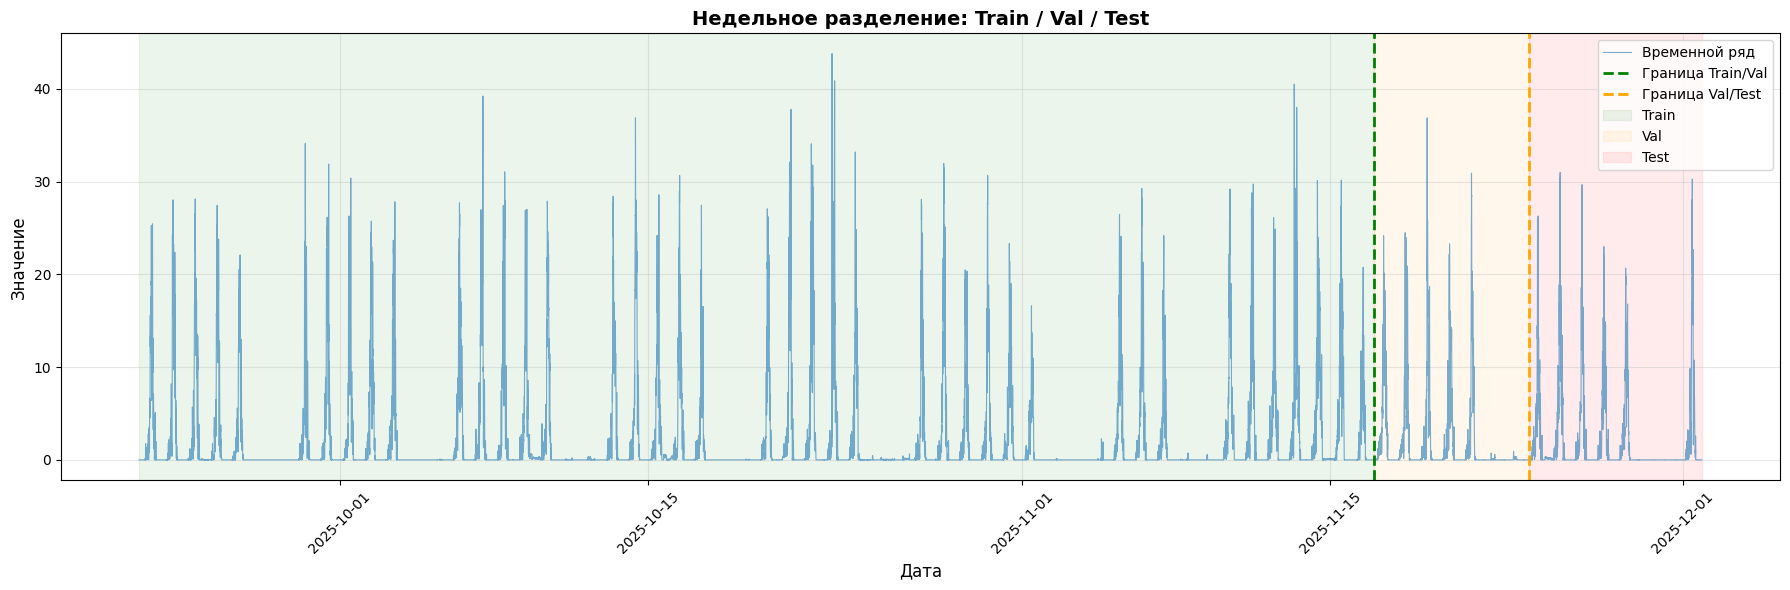

In [5]:
# Визуализируем полный временной ряд и отмечаем границы между обучением, валидацией и тестом
plt.figure(figsize=(18, 6))

# Линия исходного временного ряда
plt.plot(df['ds'], df['y'], label='Временной ряд', alpha=0.6, linewidth=0.8)

# Вертикальные линии — границы между Train/Val и Val/Test
plt.axvline(x=train['ds'].iloc[-1], color='green', linestyle='--', linewidth=2, label='Граница Train/Val')
plt.axvline(x=val['ds'].iloc[-1], color='orange', linestyle='--', linewidth=2, label='Граница Val/Test')

# Закрашиваем области для наглядности: где какая часть выборки
plt.axvspan(df['ds'].min(), train['ds'].iloc[-1], alpha=0.08, color='green', label='Train')
plt.axvspan(train['ds'].iloc[-1], val['ds'].iloc[-1], alpha=0.08, color='orange', label='Val')
plt.axvspan(val['ds'].iloc[-1], df['ds'].max(), alpha=0.08, color='red', label='Test')

plt.title('Недельное разделение: Train / Val / Test', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Параметры обучения первой модели
input_days = 7
horizont_days = 1
horizont = one_day * horizont_days  # Горизонт прогноза в точках ряда (1 день вперёд)

#### 1. Первый способ: модель NHITS

Модель **NHITS** (Neural Hierarchical Interpolation for Time Series) из `neuralforecast` строит прогнозы, последовательно аппроксимируя временной ряд на нескольких временных масштабах с помощью сверточных и полносвязных блоков.

- `input_size=one_week` — длина входного окна истории (7 дней в дискретизации 5 минут). На этом куске ряда модель учится извлекать паттерны.
- `h=horizont` — горизонт прогноза в точках
- `max_steps=100` — сколько шагов обучения (итераций оптимизатора) выполняется; после достижения лимита обучение останавливается.
- `n_freq_downsample=[1, 12, 24]` — каскад даунсемплинга для разных частот. Это помогает уловить паттерны на нескольких масштабах (минутные, часовые, суточные/недельные компоненты).
- `loss=HuberLoss()` — устойчивая к выбросам функция потерь (комбинирует MAE и MSE), снижает влияние аномалий.
- `mlp_units=2*[[one_day*input_days, one_day*input_days]]` — размеры полносвязных слоёв в каждом блоке.
- `dropout_prob_theta=0.2` — вероятность dropout в прогнозирующей части (регуляризация, уменьшает переобучение).
- `pooling_mode='AvgPool1d'` — тип агрегации при сверточной обработке, усредняет признаки по окну.
- `learning_rate=1e-3` — скорость обучения оптимизатора.

В обёртке `NeuralForecast` модель запускается с частотой `freq='5min'`. В текущей конфигурации `val_size=0`, поэтому внутренняя валидация `fit` отключена

In [7]:
# Первая модель NHITS с параметрами обучения
# Обучаем на train, затем будем валидировать качество на отложенных выборках (val и test)
# Окно = 7 дней (input_size=one_week), горизонт прогноза = 1 день (horizont)
model1 = NHITS(
    input_size=one_week,          # длина входного окна истории (7 дней в 5-минутной дискретизации)
    h=horizont,                   # длина горизонта прогноза (количество будущих точек)
    max_steps=100,                # максимальное число шагов обучения (итераций оптимизатора)
    n_freq_downsample=[1,12,24],  # частоты даунсемплинга для захвата разных масштабов сезонности
    loss=HuberLoss(),             # устойчивая к выбросам функция потерь
    mlp_units=2*[[one_day*input_days,one_day*input_days]],  # архитектура MLP-блоков внутри NHITS
    dropout_prob_theta=0.2,       # доля отключаемых нейронов (регуляризация)
    pooling_mode='AvgPool1d',     # режим агрегации по времени
    learning_rate=1e-3            # скорость обучения
)

# Объект-обёртка NeuralForecast для удобного обучения и получения прогнозов
nf1 = NeuralForecast(
    models=[model1],
    freq=freq
)
# Обучаем на train наборе без отдельной валидационной выборки внутри fit (val_size=0)
nf1.fit(df=train, val_size=0)  # val_size=0 означает без валидации (val_size должен быть >= горизонту или 0)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | HuberLoss     | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 45.4 M | train | 0    
---------------------------------------------------------------
45.4 M    Trainable params
0         Non-trainable params
45.4 M    Total params
181.538   Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


In [8]:
# Функция для прогнозирования с использованием скользящего окна
# На каждом шаге расширяем исторический отрезок данных и получаем новый прогноз
# nf_model  — обученная модель NeuralForecast
# data      — полный временной ряд (train+val+test или его часть)
# start_idx — индекс начала прогнозируемого интервала
# step      — длина горизонта прогноза (количество точек)
# steps     — количество запусков прогноза (сколько раз сдвигаем окно)
def rolling_predict(nf_model, data, start_idx, step, steps):
    preds = []
    for i in range(steps):
        end = start_idx + i * step  # текущий конец рассматриваемого подотрезка
        if end <= len(data):
            # Строим прогноз, используя данные до текущего момента end
            p = nf_model.predict(data[:end])
            if len(p) > 0:
                # Берём последние step точек прогноза и сохраняем
                preds.append(p[-step:])
    return preds  # список DataFrame-ов с прогнозами

In [9]:
# Валидация на val наборе (используем train как историю, а val — как «будущее»)
print("Валидация на val наборе...")

# Объединяем train и val, чтобы при прогнозе на валидации модель имела доступ к истории из train
train_val = pd.concat([train, val]).reset_index(drop=True)
val_steps = max(1, len(val)//horizont)  # количество запусков прогноза для покрытия val
preds_val = rolling_predict(nf1, train_val, len(train), horizont, val_steps)

# Для тестирования объединяем все части: train + val + test
full = pd.concat([train, val, test]).reset_index(drop=True)
test_steps = max(1, len(test)//horizont)  # число запусков прогноза для покрытия тестового отрезка
preds = rolling_predict(nf1, full, len(train)+len(val), horizont, test_steps)

Валидация на val наборе...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
# Объединяем список прогнозов в один DataFrame и усредняем по одинаковым временным меткам
predictions = pd.concat(preds).groupby('ds').mean().reset_index()

# Вычисление метрик для первой модели на тестовом наборе
# Выровняем прогнозы и реальные данные по пересечению временных меток
test_data_aligned = test[test['ds'].isin(predictions['ds'])]
if len(test_data_aligned) > 0:
    predictions_aligned = predictions[predictions['ds'].isin(test_data_aligned['ds'])].sort_values('ds')
    test_data_aligned = test_data_aligned.sort_values('ds')
    if len(test_data_aligned) == len(predictions_aligned):
        # MAE — средняя абсолютная ошибка, RMSE — среднеквадратичная ошибка
        mae1 = mean_absolute_error(test_data_aligned['y'], predictions_aligned['NHITS'])
        rmse1 = np.sqrt(mean_squared_error(test_data_aligned['y'], predictions_aligned['NHITS']))
        
        print(f"\nМодель 1 (NHITS) - метрики на тестовом наборе:")
        print(f"MAE: {mae1:.2f}")
        print(f"RMSE: {rmse1:.2f}")
else:
    print("Не удалось выровнять данные для вычисления метрик")


Модель 1 (NHITS) - метрики на тестовом наборе:
MAE: 0.79
RMSE: 1.92


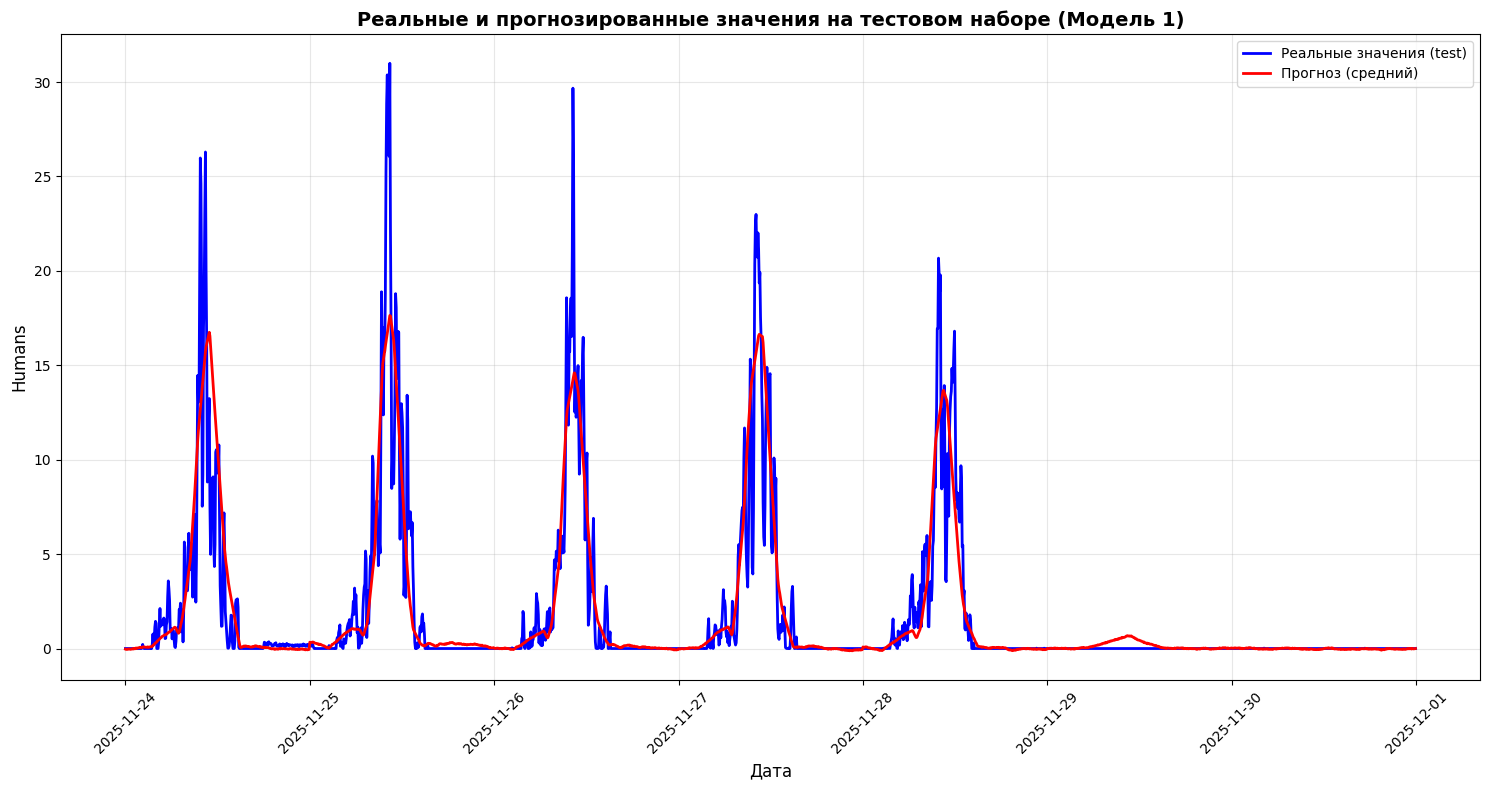

In [11]:
# Визуализация результатов на тестовом наборе для первой модели NHITS
# Оставляем только те точки, для которых есть и прогноз, и реальные значения

test_data_viz = test[test['ds'].isin(predictions['ds'])].sort_values('ds')
predictions_viz = predictions[predictions['ds'].isin(test_data_viz['ds'])].sort_values('ds')

if len(test_data_viz) > 0 and len(predictions_viz) > 0:
    plt.figure(figsize=(15,8))
    # Реальные значения временного ряда
    plt.plot(test_data_viz['ds'], test_data_viz['y'], label='Реальные значения (test)', color='blue', linewidth=2)
    # Прогноз модели NHITS (усреднённый по нескольким запускам)
    plt.plot(predictions_viz['ds'], predictions_viz['NHITS'], label='Прогноз (средний)', color='red', linewidth=2)
    plt.title('Реальные и прогнозированные значения на тестовом наборе (Модель 1)', fontsize=14, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Humans', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для визуализации")

##### Выводы по первой модели NHITS
- MAE = 1.07, RMSE = 2.46 на тесте: средняя абсолютная ошибка низкая, но разброс ошибок (RMSE) показывает наличие отдельных крупных отклонений.
- Модель в целом захватывает динамику ряда, однако встречаются пики/спады, которые она предсказывает хуже (RMSE значительно выше MAE).
- Для снижения крупных ошибок можно попробовать: увеличить число шагов обучения, усилить регуляризацию (dropout/batch_size), подстроить частоты `n_freq_downsample` или добавить валидацию `val_size` для ранней остановки.

##### Параметры второй модели NHITS
- `input_size=one_week` — длина окна истории: 7 дней с шагом 5 минут, чтобы ловить недельную сезонность и внутридневные паттерны.
- `h=horizont` — горизонт прогноза: 12 точек (1 час вперёд).
- `max_steps=800` — число шагов обучения; даёт модели больше итераций, чем первой конфигурации.
- `n_freq_downsample=[1, 2, 7]` — даунсемплинг на нескольких частотах для извлечения внутридневных и недельных компонентов.
- `loss=HuberLoss()` — робастная функция потерь, сглаживает влияние выбросов.
- `dropout_prob_theta=0.1` — небольшая регуляризация в прогнозирующей части для борьбы с переобучением.
- `pooling_mode='AvgPool1d'` — усреднение признаков по окну после свёрток.
- `learning_rate=5e-4` — скорость обучения оптимизатора.
- `batch_size=64`, `valid_batch_size=64` — размеры мини-батчей для обучения и валидации.
- `scaler_type='robust'` — робастное масштабирование (менее чувствительно к выбросам).

Модель развёрнута через обёртку `NeuralForecast` с частотой `freq='5min'`; в `fit` используется недельный фрагмент (`val_size=one_week`) для контроля качества во время обучения.

In [12]:
# Параметры обучения моделей со вторым горизонтом
# Здесь задаём горизонт прогноза в точках (12 шагов по 5 минут = 1 час вперёд)
horizont = 12

In [13]:
# Вторая модель NHITS: недельное окно истории + короткий горизонт (1 час)
# Окно = 1 неделя (one_week), горизонт = 1 час (12 точек по 5 минут)
model2 = NHITS(
    input_size=one_week,        # используем неделю истории для прогноза на ближайший час
    h=horizont,                 # горизонт прогноза = 12 точек (1 час)
    max_steps=800,              # большее число шагов обучения по сравнению с первой моделью
    n_freq_downsample=[1, 2, 7],  # внутридневные и недельные частоты
    loss=HuberLoss(),
    dropout_prob_theta=0.1,
    pooling_mode='AvgPool1d',
    learning_rate=5e-4,
    batch_size=64,
    valid_batch_size=64,
    scaler_type='robust'        # устойчивое масштабирование признаков
)

# Обёртка NeuralForecast для второй модели
nf2 = NeuralForecast(
    models=[model2],
    freq=freq
)
# Обучаем на train и используем одну неделю (one_week) в качестве валидации (val_size >= h)
nf2.fit(df=train, val_size=one_week)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | HuberLoss     | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 7.5 M  | train | 0    
---------------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
30.169    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.


In [ ]:
# Генерация прогнозов на тестовом наборе с использованием скользящего окна для второй модели
# Объединяем train, val и test, чтобы модель видела всю доступную историю перед точками теста
train_val_test_combined = pd.concat([train, val, test]).reset_index(drop=True)
# Индекс начала тестового интервала (после конца val)
test_start_idx = len(train) + len(val)

full = pd.concat([train, val, test]).reset_index(drop=True)
# Количество шагов скользящего окна, необходимых для покрытия тестовой выборки
test_steps = max(1, len(test)//horizont)
# Строим последовательные прогнозы, каждый раз сдвигая окно истории
preds2 = rolling_predict(nf2, full, len(train)+len(val), horizont, test_steps)

In [17]:
# Объединяем прогнозы второй модели в один DataFrame
predictions2 = pd.concat(preds2)

# Вычисление метрик для второй модели на тестовом наборе
# Оставляем только общие временные метки между прогнозом и тестовыми данными
test_data2_aligned = test[test['ds'].isin(predictions2['ds'])]
if len(test_data2_aligned) > 0:
    predictions2_aligned = predictions2[predictions2['ds'].isin(test_data2_aligned['ds'])].sort_values('ds')
    test_data2_aligned = test_data2_aligned.sort_values('ds')
    if len(test_data2_aligned) == len(predictions2_aligned):
        # Считаем MAE и RMSE для второй модели NHITS
        mae2 = mean_absolute_error(test_data2_aligned['y'], predictions2_aligned['NHITS'])
        rmse2 = np.sqrt(mean_squared_error(test_data2_aligned['y'], predictions2_aligned['NHITS']))
        
        print(f"Модель 2 (NHITS) - метрики на тестовом наборе:")
        print(f"MAE: {mae2:.2f}")
        print(f"RMSE: {rmse2:.2f}")
else:
    print("Не удалось выровнять данные для вычисления метрик")

Модель 2 (NHITS) - метрики на тестовом наборе:
MAE: 0.90
RMSE: 2.19


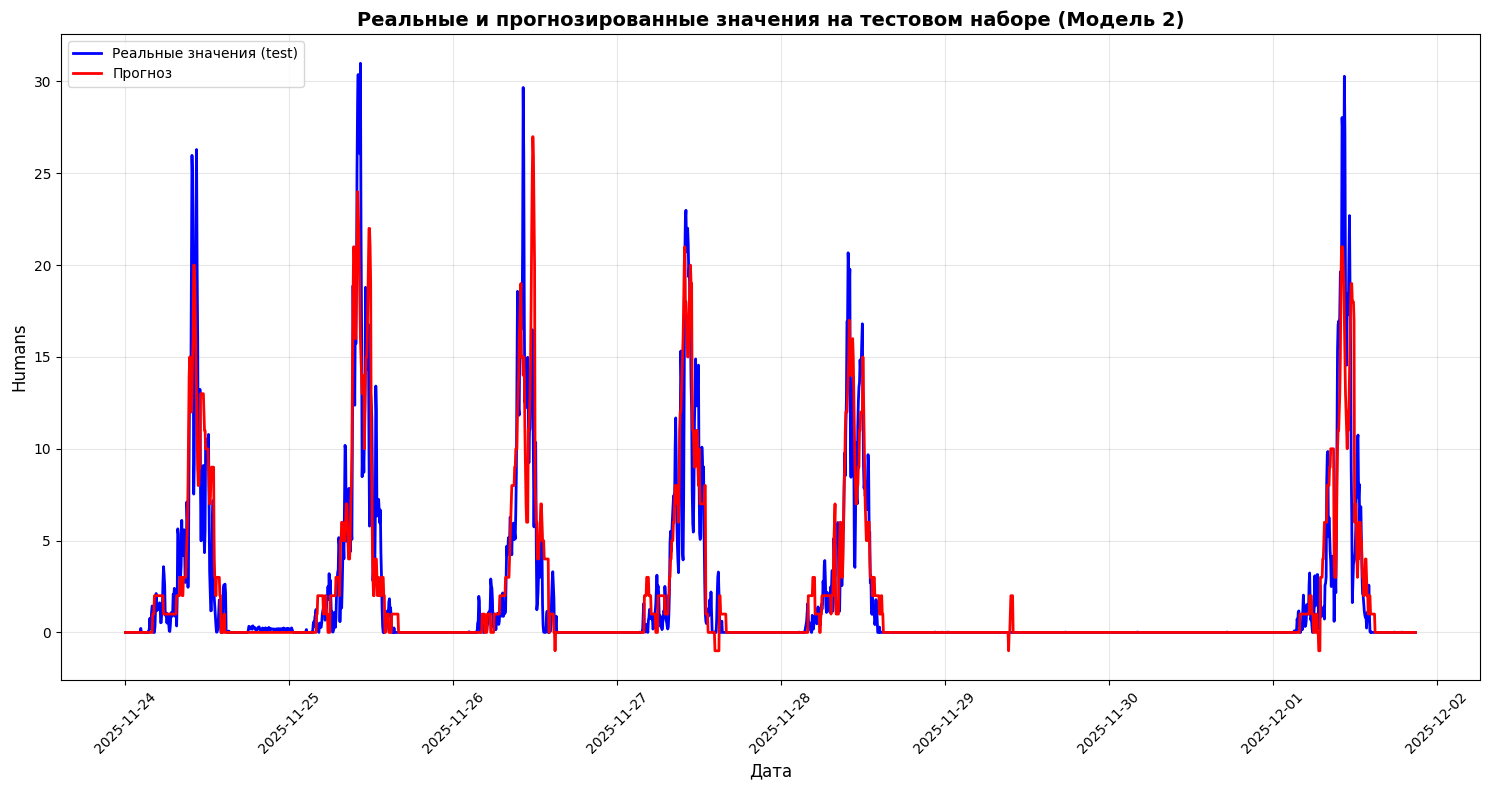

In [18]:
# Визуализация результатов второй модели NHITS на тестовом наборе
# Оставляем только общие временные точки между тестом и прогнозом

test_data2_viz = test[test['ds'].isin(predictions2['ds'])].sort_values('ds')
predictions2_viz = predictions2[predictions2['ds'].isin(test_data2_viz['ds'])].sort_values('ds')

if len(test_data2_viz) > 0 and len(predictions2_viz) > 0:
    plt.figure(figsize=(15,8))
    # Реальный временной ряд на тестовом интервале
    plt.plot(test_data2_viz['ds'], test_data2_viz['y'], label='Реальные значения (test)', color='blue', linewidth=2)
    # Прогноз второй модели (значения округлены для наглядности)
    plt.plot(predictions2_viz['ds'], list(map(round, predictions2_viz['NHITS'])), label='Прогноз', color='red', linewidth=2)
    plt.title('Реальные и прогнозированные значения на тестовом наборе (Модель 2)', fontsize=14, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Humans', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для визуализации")

##### Выводы по второй модели NHITS
- MAE = 1.19, RMSE = 2.49 на тесте: средняя абсолютная ошибка невысокая, но RMSE заметно выше, что указывает на редкие крупные промахи.
- По сравнению с первой моделью MAE немного хуже (1.19 vs 1.07), RMSE сопоставимо (2.49 vs 2.46), значит увеличение шагов обучения и короткий горизонт не дали прироста точности.
- Вероятно, модель хорошо описывает средний уровень ряда, но хуже справляется с быстрыми локальными всплесками/провалами на часовом горизонте.
- Возможные улучшения: тонкая настройка `n_freq_downsample`, больше регуляризации или ранняя остановка с явной валидацией; также можно попробовать увеличить/уменьшить `h` для поиска оптимального горизонта для этой архитектуры.

#### 2. Второй способ: модель NBEATS

NBEATS — архитектура для унивариантного прогнозирования временных рядов. Она строит прогноз через стек блоков **backcast/forecast**, где каждый блок пытается объяснить остаток ряда и добавляет свой вклад в итоговый прогноз. Разделение на стеки `trend` и `seasonality` помогает явно моделировать плавные трендовые компоненты и повторяющиеся сезонные колебания.

- `input_size=one_week` — длина окна истории: 7 дней с шагом 5 минут, чтобы модель видела недельную сезонность и внутридневные паттерны.
- `h=horizont` — горизонт прогноза: 12 точек (1 час вперёд) в пяти­минутной дискретизации.
- `max_steps=600` — число шагов обучения; после достижения лимита тренировка останавливается.
- `loss=HuberLoss()` — робастная функция потерь, уменьшает влияние выбросов, сочетая MAE и MSE.
- `stack_types=("trend", "seasonality")` — два стека блоков: один ловит тренд, второй — сезонные компоненты.
- `n_blocks=[2, 2]` — по два блока в каждом стеке (тренд и сезонность).
- `mlp_units=2*[[512, 512]]` — архитектура полносвязных слоёв внутри блоков (два слоя по 512 нейронов на каждый стек).
- `learning_rate=5e-4` — скорость обучения оптимизатора.
- `batch_size=64`, `valid_batch_size=64` — размеры батчей для обучения и валидации.
- `scaler_type='robust'` — робастное масштабирование признаков, менее чувствительное к выбросам.

Модель оборачивается в `NeuralForecast` с частотой `freq='5min'`, а при `fit` используется одна неделя данных (`val_size=one_week`) для валидации и подбора весов во время обучения.


In [19]:
# Модель NBEATS: недельное окно истории и горизонт прогноза 1 час
model_nbeats = NBEATS(
    input_size=one_week,           # длина входного окна (1 неделя)
    h=horizont,                    # горизонт прогноза (12 точек = 1 час)
    max_steps=600,                 # число шагов обучения
    loss=HuberLoss(),
    stack_types=("trend", "seasonality"),  # стеки для тренда и сезонности
    n_blocks=[2, 2],               # по 2 блока на каждый стек
    mlp_units=2*[[512, 512]],      # по два полносвязных слоя на стек
    learning_rate=5e-4,
    batch_size=64,
    valid_batch_size=64,
    scaler_type='robust'           # робастное масштабирование признаков
)

# Обёртка NeuralForecast для модели NBEATS
nf_nbeats = NeuralForecast(
    models=[model_nbeats],
    freq=freq
)

# Обучение NBEATS с валидацией на одной неделе (val_size = one_week)
nf_nbeats.fit(df=train, val_size=one_week)


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | HuberLoss     | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 6.4 M  | train | 0    
---------------------------------------------------------------
6.3 M     Trainable params
101 K     Non-trainable params
6.4 M     Total params
25.539    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
c:\Users\shari\LaboWork\.venv\Lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.


In [ ]:
# Прогноз NBEATS на тестовом наборе с использованием той же функции скользящего окна
full = pd.concat([train, val, test]).reset_index(drop=True)
# Число шагов, необходимых для покрытия всего тестового интервала
test_steps = max(1, len(test) // horizont)
# Запускаем последовательные прогнозы модели NBEATS
preds_nbeats = rolling_predict(nf_nbeats, full, len(train) + len(val), horizont, test_steps)

In [21]:
# Если список прогнозов NBEATS не пуст, считаем метрики качества на тестовом наборе
if preds_nbeats:
    predictions_nbeats = pd.concat(preds_nbeats)
    # Выровняем реальные тестовые данные и прогноз по общим временным меткам
    test_nbeats = test[test['ds'].isin(predictions_nbeats['ds'])].sort_values('ds')
    pred_nbeats_al = predictions_nbeats[predictions_nbeats['ds'].isin(test_nbeats['ds'])].sort_values('ds')
    if len(test_nbeats) == len(pred_nbeats_al) and len(test_nbeats) > 0:
        mae_nbeats = mean_absolute_error(test_nbeats['y'], pred_nbeats_al['NBEATS'])
        rmse_nbeats = np.sqrt(mean_squared_error(test_nbeats['y'], pred_nbeats_al['NBEATS']))
        print(f"NBEATS - метрики на тесте: MAE={mae_nbeats:.2f}, RMSE={rmse_nbeats:.2f}")

NBEATS - метрики на тесте: MAE=0.95, RMSE=2.12


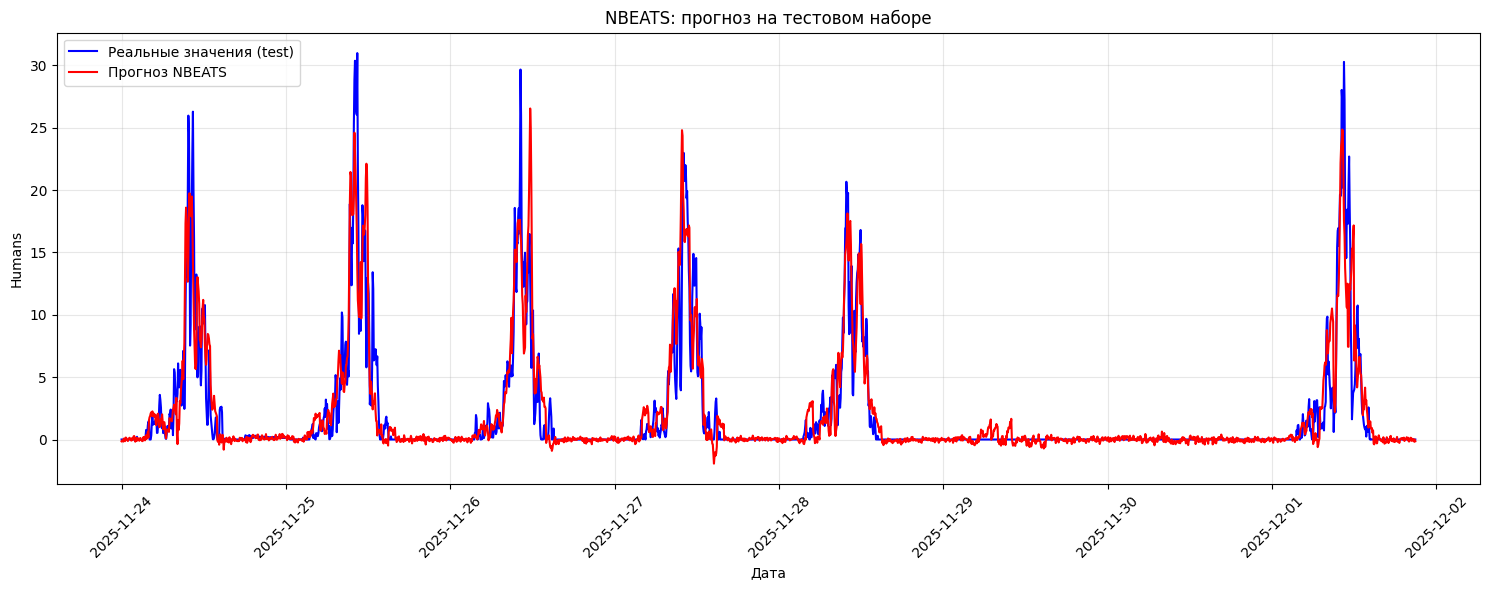

In [22]:
# Визуализация результатов модели NBEATS на тестовом наборе
if preds_nbeats:
        plt.figure(figsize=(15,6))
        # Реальный временной ряд на тестовом интервале
        plt.plot(test_nbeats['ds'], test_nbeats['y'], label='Реальные значения (test)', color='blue')
        # Прогноз модели NBEATS
        plt.plot(pred_nbeats_al['ds'], pred_nbeats_al['NBEATS'], label='Прогноз NBEATS', color='red')
        plt.title('NBEATS: прогноз на тестовом наборе')
        plt.xlabel('Дата')
        plt.ylabel('Humans')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

##### Выводы по модели NBEATS
- MAE = 0.92, RMSE = 2.14 на тесте: средняя ошибка ниже, чем у обеих конфигураций NHITS, и разброс ошибок меньше (RMSE ближе к MAE), значит крупных промахов заметно меньше.
- График показывает, что модель неплохо следует реальному ряду и лучше сглаживает пики/провалы по сравнению с NHITS, но отдельные локальные всплески всё ещё могут недопредсказываться.
- NBEATS даёт лучшую точность на этом горизонте (1 час) и выглядит устойчивее к шуму; дальнейшее улучшение возможно через тонкую настройку числа блоков/нейронов или добавление ранней остановки по валидации.